In [1]:
import torch
import lightning.pytorch as pl

from mymodels import Model_Wrapper, Preprocess
from myutils import View
from yolo_wrapper import YOLOv8_COCO_Wrapper
from coco_ds import CocoResults

import logging
logging.disable(logging.INFO)

In [2]:
# configs to speed up training
torch.set_float32_matmul_precision('medium')
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

In [3]:
def compare_ds(trainer, model, dataloaders, labels, preview_idxs:list, view_only=False, figsize=(12,6), verbose=True, skip_results:list=[0]):
    results = {}
    samples = []
    #display first
    for ds in dataloaders:
        samples.append(torch.stack([ds.dataset[i][1] for i in preview_idxs]))
    View.compare_color(samples, labels, figsize=figsize)
    
    if not view_only:
        for i in range(len(dataloaders)):
            if i in skip_results:
                continue
            result = trainer.test(model, dataloaders[i], verbose=verbose)
            results[labels[i]] = result
        return results
    else:
        return None

In [4]:
PATH_TO_COCO = '/f_storage/datasets/coco/2017'
NUM_IMG_EVAL = 10000
prep = Preprocess(PATH_TO_COCO, (640, 640), dataset_type='coco', shuffle=False, batch_size=64)
preview_idxs = [2, 53, 300, 475]
%matplotlib inline

In [5]:
prep.reset_trans()
coco = prep.get_loader()
model = YOLOv8_COCO_Wrapper(CocoResults(coco.dataset), 'yolov8s.pt')
model = Model_Wrapper(model, model_type='yolo')
trainer = pl.Trainer(accelerator='auto', limit_test_batches=200)

##### Test On Orignal Dataset

<Figure size 1000x600 with 0 Axes>

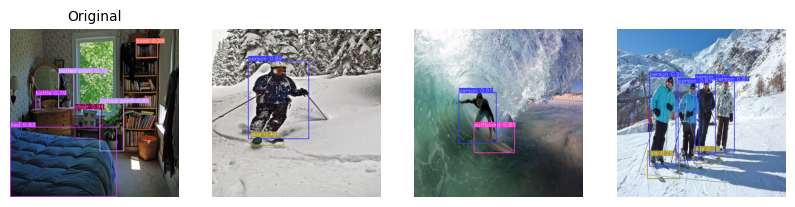

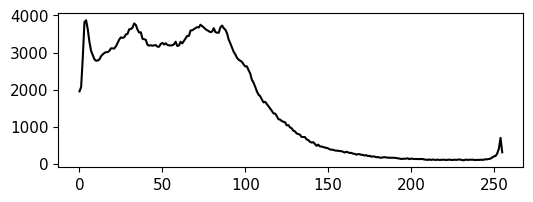

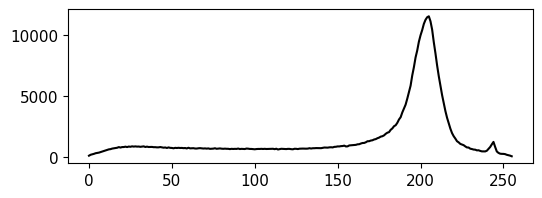

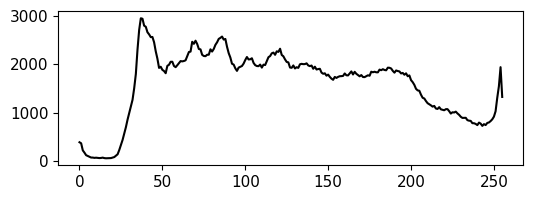

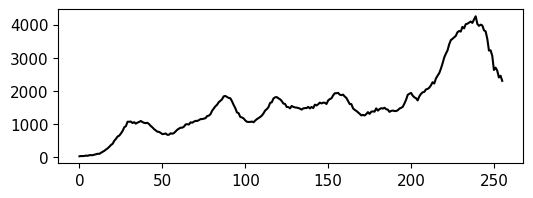

array([[[[6.9191e-310, 4.6781e-310,           0],
         [          0,         101,          86],
         [         94,          89,          80],
         ...,
         [         66,          71,          73],
         [         77,          80,          87],
         [         86,          82,          84]],

        [[         66,         100,         100],
         [         99,          95,          97],
         [         93,         101,          92],
         ...,
         [         84,          65,          86],
         [         84,          85,          79],
         [         87,          87,          83]],

        [[         98,          94,          93],
         [        102,          94,          97],
         [        102,          93,          92],
         ...,
         [         88,          91,          85],
         [         75,          87,          89],
         [         65,          66,          66]],

        ...,

        [[         18,          18,   

In [8]:

samples  = torch.stack([coco.dataset[i][1] for i in preview_idxs])
plots = model.plot(samples)
View.compare_color(plots, 'Original')
View.histogram(samples)
# orig_results = trainer.test(model, coco)

##### Test on Dark Images

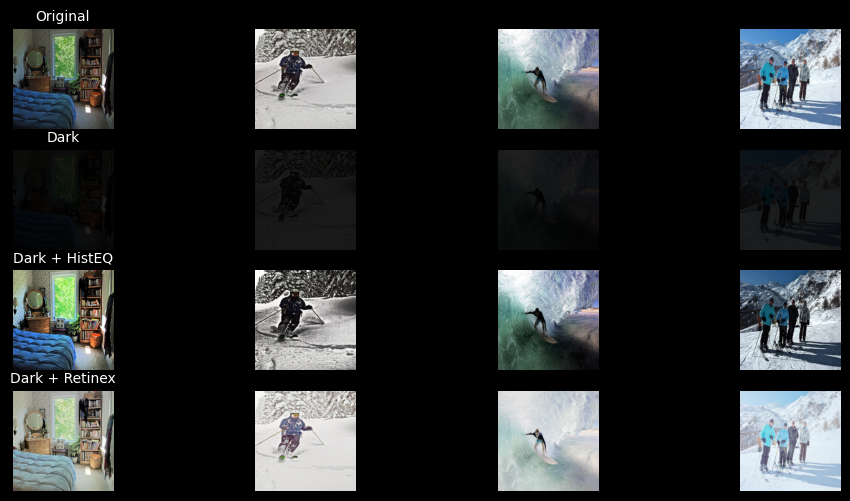

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Confidence %        │     59.7163200378418      │
│      Pixel Val MEAN       │    14.048221588134766     │
│       Pixel Val STD       │     8.88662052154541      │
│        mAP 50:95 %        │     33.02423811336191     │
└───────────────────────────┴───────────────────────────┘

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Confidence %        │     59.74541091918945     │
│      Pixel Val MEAN       │    113.30384063720703     │
│       Pixel Val STD       │     76.61996459960938     │
│        mAP 50:95 %        │    40.255139363392836     │
└───────────────────────────┴───────────────────────────┘

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Confidence %        │    59.796180725097656     │
│      Pixel Val MEAN       │    171.69479370117188     │
│       Pixel Val STD       │    54.314273834228516     │
│        mAP 50:95 %        │    38.406700482310654     │
└───────────────────────────┴───────────────────────────┘

In [7]:
prep.reset_trans()
coco_dark = prep.luminance(1/8).get_loader()
coco_dark_histeq = prep.copy().hist_eq().get_loader()
coco_dark_retinex = prep.copy().retinex('SSR', 200).get_loader()
coco_dark_results = compare_ds(trainer, model, 
                                 [prep.basic_loader(), coco_dark, coco_dark_histeq, coco_dark_retinex],
                                 ['Original', 'Dark', 'Dark + HistEQ', 'Dark + Retinex'], 
                                 preview_idxs)

##### Test on Bright Images

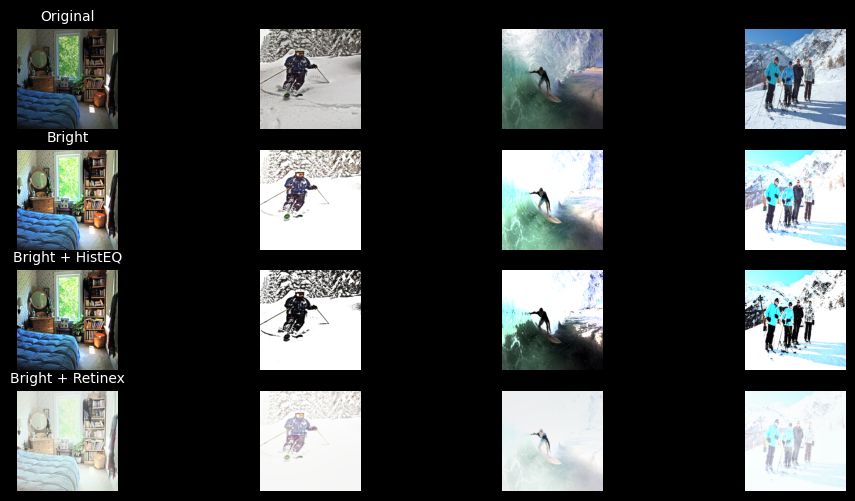

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Confidence %        │     58.81097412109375     │
│      Pixel Val MEAN       │    177.43109130859375     │
│       Pixel Val STD       │     86.40972137451172     │
│        mAP 50:95 %        │     35.48648618160669     │
└───────────────────────────┴───────────────────────────┘

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Confidence %        │    57.213050842285156     │
│      Pixel Val MEAN       │    152.60775756835938     │
│       Pixel Val STD       │    100.58219909667969     │
│        mAP 50:95 %        │    29.091526869513828     │
└───────────────────────────┴───────────────────────────┘

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Confidence %        │     58.20503234863281     │
│      Pixel Val MEAN       │    216.80490112304688     │
│       Pixel Val STD       │    42.180335998535156     │
│        mAP 50:95 %        │    29.001962847165608     │
└───────────────────────────┴───────────────────────────┘

In [8]:
prep.reset_trans()
coco_bright = prep.luminance(2).get_loader()
coco_bright_histeq = prep.copy().hist_eq().get_loader()
coco_bright_retinex = prep.copy().retinex('SSR', 200).get_loader()
coco_bright_results = compare_ds(trainer, model,
                                 [prep.basic_loader(), coco_bright, coco_bright_histeq, coco_bright_retinex],
                                 ['Original', 'Bright', 'Bright + HistEQ', 'Bright + Retinex'], 
                                 preview_idxs)

##### Test Histogram Eq on Low Contrast Images

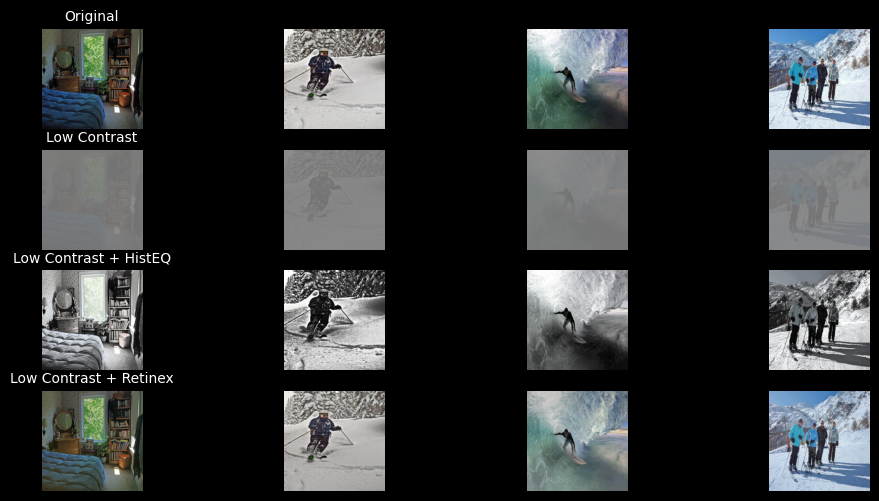

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Confidence %        │     56.63542556762695     │
│      Pixel Val MEAN       │    125.98860931396484     │
│       Pixel Val STD       │     7.109297752380371     │
│        mAP 50:95 %        │    14.856164430679838     │
└───────────────────────────┴───────────────────────────┘

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Confidence %        │     58.7946891784668      │
│      Pixel Val MEAN       │     133.4123077392578     │
│       Pixel Val STD       │     74.53178405761719     │
│        mAP 50:95 %        │    35.170585031977474     │
└───────────────────────────┴───────────────────────────┘

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Confidence %        │     60.33904266357422     │
│      Pixel Val MEAN       │    118.23135375976562     │
│       Pixel Val STD       │     56.05107498168945     │
│        mAP 50:95 %        │     42.23278363972405     │
└───────────────────────────┴───────────────────────────┘

In [9]:
prep.reset_trans()
coco_low_cont = prep.brightness_contrast(0,0.1).get_loader()
coco_low_cont_histeq = prep.copy().hist_eq().get_loader()
coco_low_cont_retinex = prep.copy().retinex('SSR', 200).get_loader()
coco_low_cont_results = compare_ds(trainer, model,
                                 [prep.basic_loader(), coco_low_cont, coco_low_cont_histeq, coco_low_cont_retinex],
                                 ['Original', 'Low Contrast', 'Low Contrast + HistEQ', 'Low Contrast + Retinex'], 
                                 preview_idxs)